# SVM

## Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

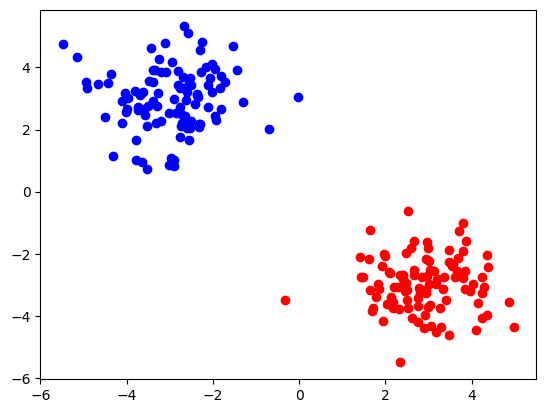

In [2]:
n = 100
d = 2
ranges = 3
postives = np.random.randn(n, d) + np.array([ranges, -ranges])
negatives = np.random.randn(n, d) + np.array([-ranges, ranges])

plt.scatter(postives[:, 0], postives[:, 1], color='red')
plt.scatter(negatives[:, 0], negatives[:, 1], color='blue')

In [3]:
postives.shape, negatives.shape

((100, 2), (100, 2))

In [4]:
postives = np.column_stack((postives, np.ones(n)))
negatives = np.column_stack((negatives, np.zeros(n)))

data = np.vstack((postives, negatives))
np.random.shuffle(data)

In [5]:
X, y = data[:, :-1], data[:, -1] 
X.shape, y.shape

((200, 2), (200,))

In [6]:
train_size = int(2*n*0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((160, 2), (160,), (40, 2), (40,))

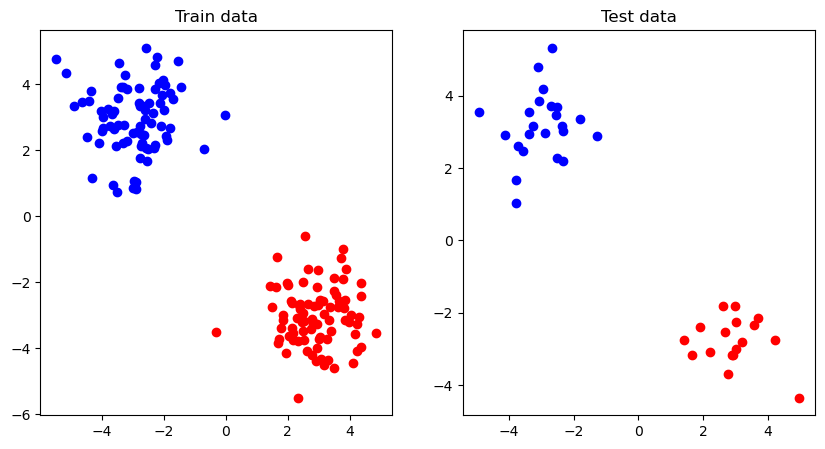

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red')
_ = axes[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue')
_ = axes[0].set_title('Train data')
_ = axes[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red')
_ = axes[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue')
_ = axes[1].set_title('Test data')


In [8]:
np.sum(y_train == 1) / len(y_train), np.sum(y_train == 0) / len(y_train)
np.sum(y_test == 1) / len(y_test), np.sum(y_test == 0) / len(y_test)

(0.51875, 0.48125)

(0.425, 0.575)

## SVM with inbuilt functions

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

SVC(kernel='linear')

Accuracy: 1.00


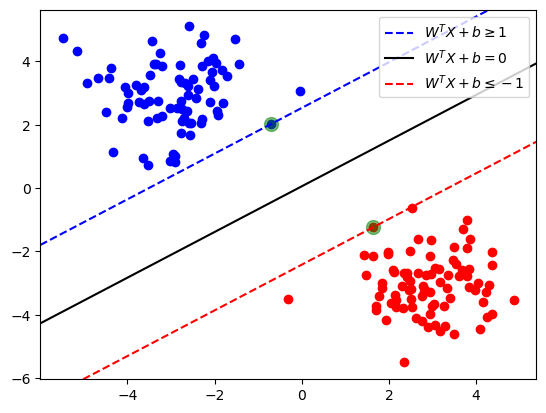

In [10]:
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue')
plt.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], color='green', s=100, alpha=0.5)
plt.axline((0, -svm_model.intercept_[0] / svm_model.coef_[0][1] - 1 / svm_model.coef_[0][1]), slope=-svm_model.coef_[0][0] / svm_model.coef_[0][1], color='blue', linestyle='dashed', label='$W^TX + b \geq 1 $')
plt.axline((0, -svm_model.intercept_[0] / svm_model.coef_[0][1]), slope=-svm_model.coef_[0][0] / svm_model.coef_[0][1], color='black',label='$W^TX + b = 0 $')
plt.axline((0, -svm_model.intercept_[0] / svm_model.coef_[0][1] + 1 / svm_model.coef_[0][1]), slope=-svm_model.coef_[0][0] / svm_model.coef_[0][1], color='red', linestyle='dashed', label = '$W^TX + b \leq -1 $')
plt.legend()
plt.show()


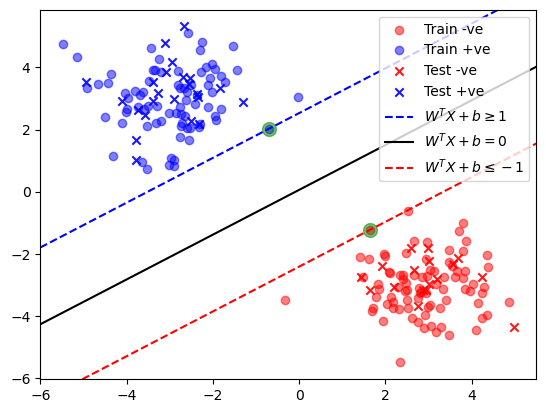

In [11]:
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red' , alpha=0.5, label='Train -ve')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue' , alpha=0.5 , label='Train +ve')
plt.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], color='green', s=100, alpha=0.5)

plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red', marker='x' , alpha=0.9 , label='Test -ve')
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue', marker='x', alpha=0.9, label='Test +ve')


plt.axline((0, -svm_model.intercept_[0] / svm_model.coef_[0][1] - 1 / svm_model.coef_[0][1]), slope=-svm_model.coef_[0][0] / svm_model.coef_[0][1], color='blue', linestyle='dashed', label='$W^TX + b \geq 1 $')
plt.axline((0, -svm_model.intercept_[0] / svm_model.coef_[0][1]), slope=-svm_model.coef_[0][0] / svm_model.coef_[0][1], color='black',label='$W^TX + b = 0 $')
plt.axline((0, -svm_model.intercept_[0] / svm_model.coef_[0][1] + 1 / svm_model.coef_[0][1]), slope=-svm_model.coef_[0][0] / svm_model.coef_[0][1], color='red', linestyle='dashed', label = '$W^TX + b \leq -1 $')
plt.legend()
plt.show()


## Custom implementation to solve SVM

In [47]:
import numpy as np
from cvxopt import matrix, solvers

class SupportVectorM_Classifier:
    def __init__(self, kernel='linear', Constraint = 1.0, epsilon = 1e-6):
        self.Constraint = Constraint
        self.kernel = kernel
        self.implemented_kernels = ['linear', 'rbf']
        self.epsilon = epsilon
        if kernel not in self.implemented_kernels:
            self.kernel = self.implemented_kernels[0]
        self.gamma = None

    def _compute_kernel(self, X1, X2):
        if self.kernel == 'linear':
            return np.dot(X1, X2.T)
        elif self.kernel == 'rbf':
            if self.gamma is None:
                std_dev = np.std(self.X_train)
                self.gamma = 1 / (2 * std_dev**2)
            X1_sq = np.sum(X1**2, axis=1)[:, None]
            X2_sq = np.sum(X2**2, axis=1)[None, :]
            sq_dists = X1_sq + X2_sq - 2 * np.dot(X1, X2.T)
            return np.exp(-self.gamma * sq_dists)

    def svm_dual_qp(self, X, y):
        self.K = self._compute_kernel(X, X)
            
        P = matrix(np.outer(y, y) * self.K) 
        q = matrix(-np.ones(self.n))
            
        # Constraint: 0 <= alpha <= C
        G_lower_bound_std = np.diag(np.ones(self.n) * -1)
        h_lower_bound_std = np.zeros(self.n)
        G_higher_bound_slack = np.identity(self.n)
        h_higher_bound_slack = np.ones(self.n) * self.Constraint
        
        ## G alpha <= h
        
        G = matrix(np.vstack((G_lower_bound_std, G_higher_bound_slack)))
        h = matrix(np.hstack((h_lower_bound_std, h_higher_bound_slack)))
        
        #  Constraint: sum y_i alpha_i = 0
        ## A y = b
        A = matrix(y.astype(float), (1, self.n))
        b = matrix(0.0)
        
        ## cv Opt :: max P - q  ; s.t. G a <= h & A y = b
        sol = solvers.qp(P, q, G, h, A, b)
        alpha = np.ravel(sol['x'])
        return alpha
    
    def fit(self, X, y, C = None):
        y = np.where(y == 0, -1, 1)
        self.X_train = X
        self.y_train = y
        self.n, self.m = X.shape
        self.classes = np.unique(y)
        if C:
            self.Constraint = C
        self.alpha = self.svm_dual_qp(self.X_train, self.y_train)
        # print(f'{self.alpha.shape = }')
        
        sv = self.alpha > self.epsilon
        self.sv_alpha = self.alpha[sv]
        self.sv_X = self.X_train[sv]
        self.sv_y = self.y_train[sv]
        self.sv_K = self._compute_kernel(self.sv_X, self.sv_X)
        
        # print(f'{self.sv_alpha.shape = }')
        # print(f'{self.sv_X.shape = }')
        # print(f'{self.sv_y.shape = }')
        # print(f'{self.sv_K.shape = }')
        
        if self.kernel == 'linear':
            self.w = np.sum((self.sv_alpha * self.sv_y)[:, None] * self.sv_X, axis=0)
        else:
            self.w = None
            
        # print(f'{self.w.shape = }')
        self.b = np.mean([
            self.sv_y[i] - np.sum((self.sv_alpha * self.sv_y) * self.sv_K[:, i])
            for i in range(len(self.sv_alpha))
        ])
        # print(f'{self.b.shape = }')
        # return self.w, self.b

    def predict(self, X):
        if self.kernel == 'linear':
            decision = np.dot(X, self.w) + self.b
        elif self.kernel == 'rbf':
            new_K = self._compute_kernel(X, self.sv_X)
            decision = np.dot(new_K, self.sv_alpha * self.sv_y) + self.b
        # print(decision , self.sv_alpha)
        return np.where(np.sign(decision) == -1, 0, 1)

    def acc_score(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

In [48]:
from sklearn.metrics import accuracy_score

svm_model = SupportVectorM_Classifier(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

     pcost       dcost       gap    pres   dres
 0: -3.2897e+01 -3.7601e+02  2e+03  3e+00  6e-15
 1: -1.9641e+01 -2.2522e+02  4e+02  4e-01  5e-15
 2: -9.3556e+00 -4.6669e+01  6e+01  5e-02  1e-14
 3: -6.4694e+00 -1.2861e+01  9e+00  7e-03  3e-15
 4: -6.9584e+00 -7.9328e+00  1e+00  7e-04  2e-15
 5: -7.1551e+00 -7.4123e+00  3e-01  1e-04  1e-15
 6: -7.2285e+00 -7.2610e+00  4e-02  9e-06  1e-15
 7: -7.2419e+00 -7.2424e+00  5e-04  9e-08  2e-15
 8: -7.2421e+00 -7.2421e+00  5e-06  9e-10  2e-15
Optimal solution found.
Accuracy: 0.95


In [22]:
svm_model.sv_X

array([[ 1.6375166 , -1.23554642],
       [-0.7080921 ,  2.01801344],
       [ 2.53670828, -0.61308005]])

In [19]:
svm_model.w , svm_model.b

(array([ 0.29160696, -0.4044811 ]), 0.019255122723058182)

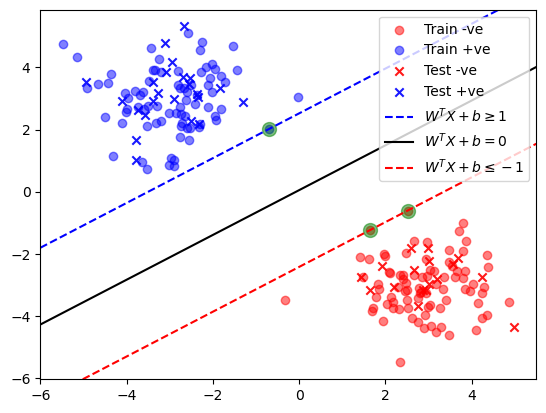

In [23]:
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red' , alpha=0.5, label='Train -ve')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue' , alpha=0.5 , label='Train +ve')

plt.scatter(svm_model.sv_X[:, 0], svm_model.sv_X[:, 1], color='green', s=100, alpha=0.5)

plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red', marker='x' , alpha=0.9 , label='Test -ve')
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue', marker='x', alpha=0.9, label='Test +ve')


plt.axline((0, -svm_model.b / svm_model.w[1] - 1 / svm_model.w[1]), slope=-svm_model.w[0] / svm_model.w[1], color='blue', linestyle='dashed', label='$W^TX + b \geq 1 $')
plt.axline((0, -svm_model.b / svm_model.w[1]), slope=-svm_model.w[0] / svm_model.w[1], color='black',label='$W^TX + b = 0 $')
plt.axline((0, -svm_model.b / svm_model.w[1] + 1 / svm_model.w[1]), slope=-svm_model.w[0] / svm_model.w[1], color='red', linestyle='dashed', label = '$W^TX + b \leq -1 $')
plt.legend()
plt.show()


# SVM Soft Margin

### data

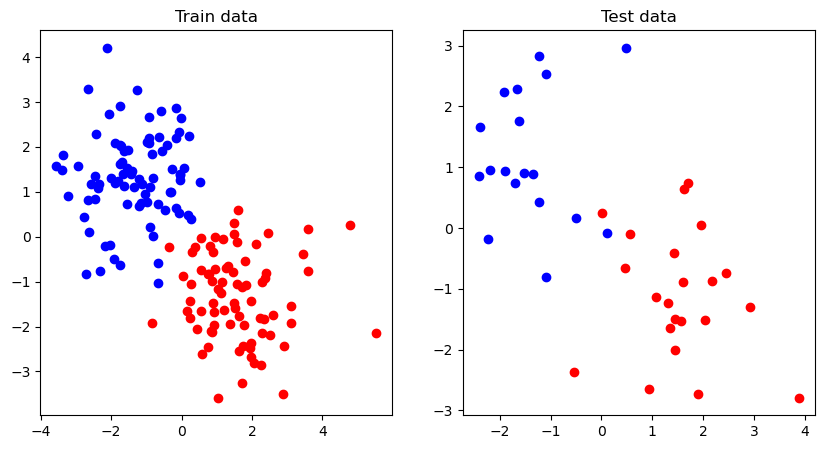

In [41]:
n = 100
d = 2
ranges = 1.4
postives = np.random.randn(n, d) + np.array([ranges, -ranges])
negatives = np.random.randn(n, d) + np.array([-ranges, ranges])
postives = np.column_stack((postives, np.ones(n)))
negatives = np.column_stack((negatives, np.zeros(n)))

data = np.vstack((postives, negatives))
np.random.shuffle(data)
X, y = data[:, :-1], data[:, -1] 
train_size = int(2*n*0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red')
_ = axes[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue')
_ = axes[0].set_title('Train data')
_ = axes[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red')
_ = axes[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue')
_ = axes[1].set_title('Test data')
plt.show()

In [42]:
def plot_svm_classification(X_train, X_test, y_train, y_test,support_vectors, w, b ):
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red' , alpha=0.5, label='Train -ve')
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue' , alpha=0.5 , label='Train +ve')
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], color='green', s=100, alpha=0.5)

    plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red', marker='x' , alpha=0.9 , label='Test -ve')
    plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue', marker='x', alpha=0.9, label='Test +ve')

    plt.axline((0, -b / w[1] - 1 / w[1]), slope=-w[0] / w[1], color='blue', linestyle='dashed', label='$W^TX + b \geq 1 $')
    plt.axline((0, -b / w[1]), slope=-w[0] / w[1], color='black',label='$W^TX + b = 0 $')
    plt.axline((0, -b / w[1] + 1 / w[1]), slope=-w[0] / w[1], color='red', linestyle='dashed', label = '$W^TX + b \leq -1 $')
    plt.legend()
    plt.show()

### inbuilt

SVC(kernel='linear')

Accuracy: 0.95


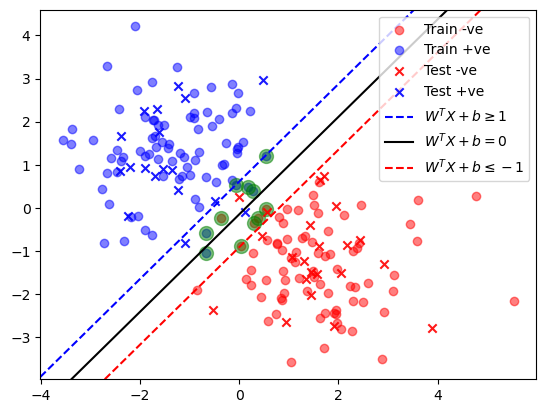

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

plot_svm_classification(X_train, X_test, y_train, y_test,svm_model.support_vectors_, svm_model.coef_[0], svm_model.intercept_[0])

### my implementation

     pcost       dcost       gap    pres   dres
 0: -3.2897e+01 -3.7601e+02  2e+03  3e+00  6e-15
 1: -1.9641e+01 -2.2522e+02  4e+02  4e-01  5e-15
 2: -9.3556e+00 -4.6669e+01  6e+01  5e-02  1e-14
 3: -6.4694e+00 -1.2861e+01  9e+00  7e-03  3e-15
 4: -6.9584e+00 -7.9328e+00  1e+00  7e-04  2e-15
 5: -7.1551e+00 -7.4123e+00  3e-01  1e-04  1e-15
 6: -7.2285e+00 -7.2610e+00  4e-02  9e-06  1e-15
 7: -7.2419e+00 -7.2424e+00  5e-04  9e-08  2e-15
 8: -7.2421e+00 -7.2421e+00  5e-06  9e-10  2e-15
Optimal solution found.
Accuracy: 0.95


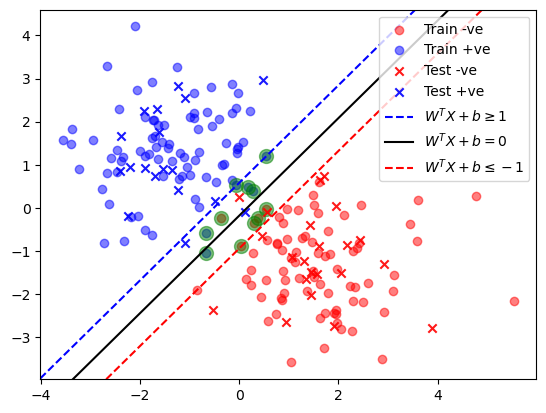

In [49]:
svm_model = SupportVectorM_Classifier(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

plot_svm_classification(X_train, X_test, y_train, y_test,svm_model.sv_X, svm_model.w, svm_model.b)